In [97]:
import numpy as np
from skimage.io import imread
from skimage.filters import gaussian
from skimage.transform import rescale
import matplotlib.pyplot as plt

In [98]:
image = imread('./sift_test.png', as_gray = True)
im_h, im_w = image.shape
print (im_h, im_w)

401 564


In [99]:
n_octaves = int(np.log(min(im_h, im_w))/np.log(2))
n_octaves = min(n_octaves, 4)
print(n_octaves)
n_scales = 3

4


In [100]:
n_images = n_scales + 3
sigma = 1.6
k = 2 ** (1/n_scales)
sigma_scales = np.zeros(n_images)
sigma_scales[0] = sigma
for i in range(1, n_images):
    sigma_scales[i] = k * sigma_scales[i-1]
sigma_scales

array([1.6       , 2.01587368, 2.53984168, 3.2       , 4.03174736,
       5.07968337])

In [101]:
image = rescale(image, 2)
image.shape

(802, 1128)

In [102]:
img_pyramid = []
dog_pyramid = []
image_s0 = gaussian(image, scale)
for octave in range(n_octaves):
    img_octave = []
    dog_octave = []
    img_octave.append(image_s0)
    for i in range(1,n_images):
        gauss_im = gaussian(img_octave[0], sigma_scales[i])
        img_octave.append(gauss_im)
        dog = img_octave[i] - img_octave[i-1]
        dog_octave.append(dog)
    image_s0 = rescale(img_octave[n_scales], 0.5, anti_aliasing=False)
    img_pyramid.append(img_octave)
    dog_pyramid.append(dog_octave)

-0.041555571742338926


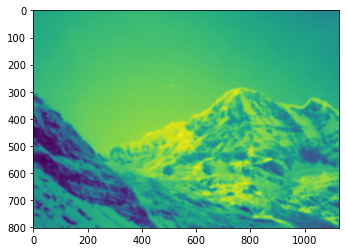

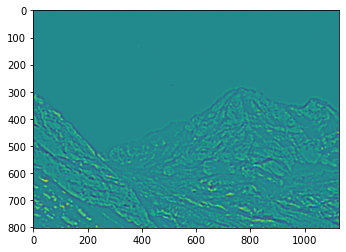

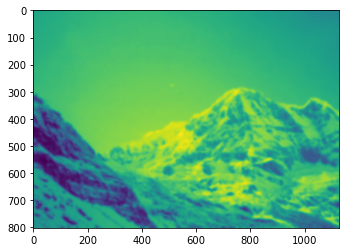

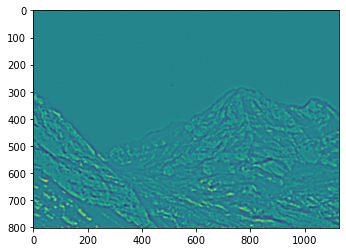

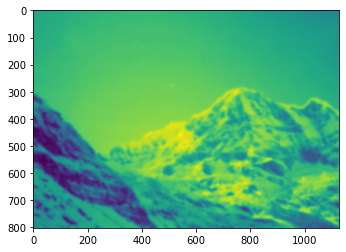

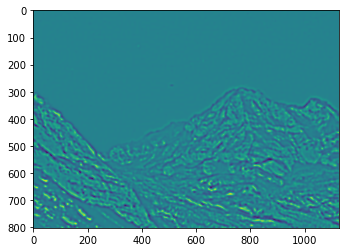

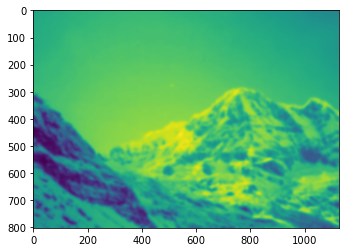

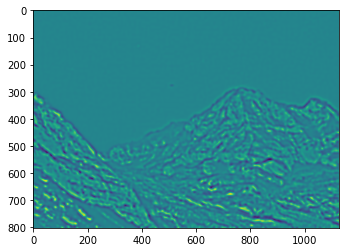

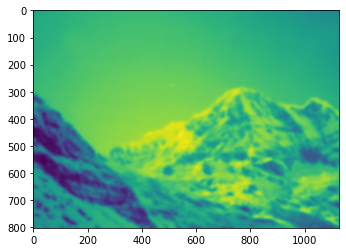

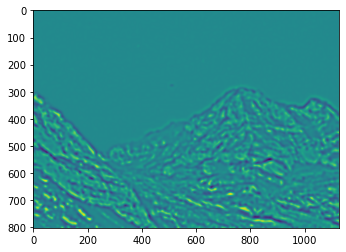

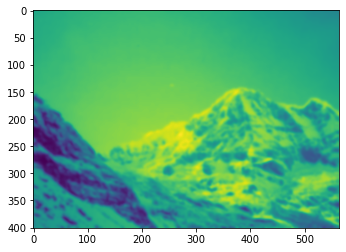

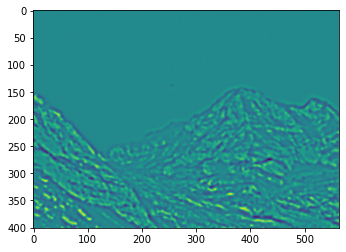

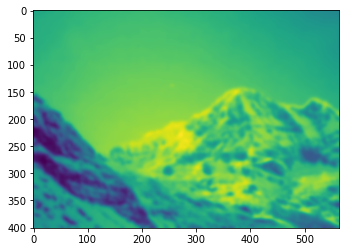

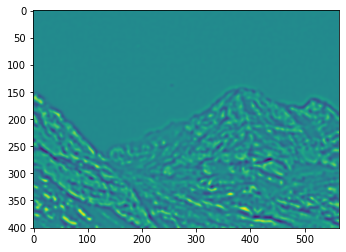

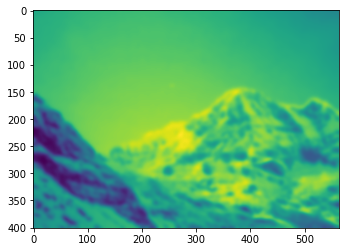

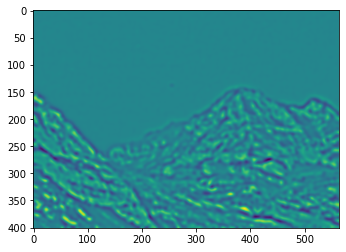

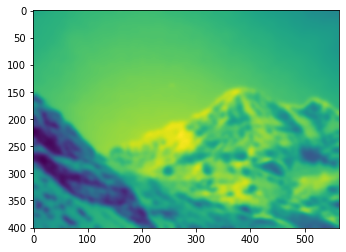

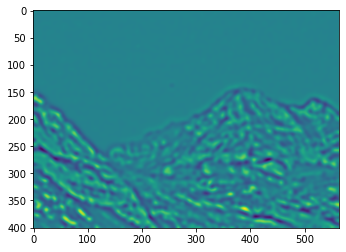

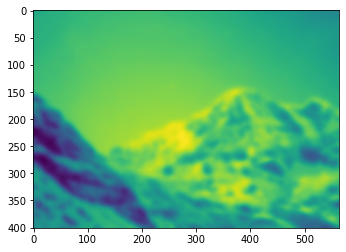

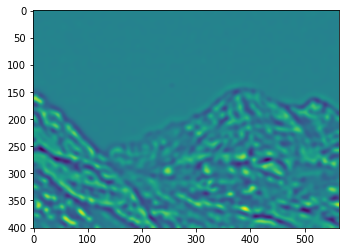

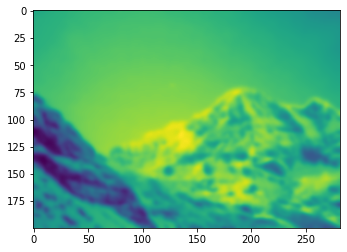

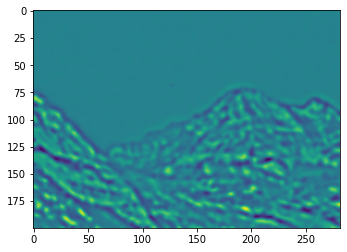

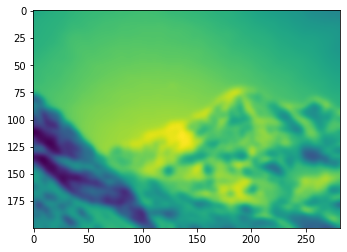

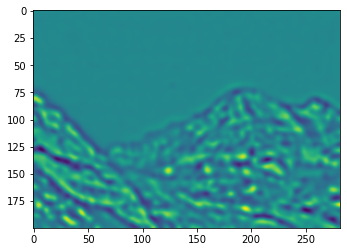

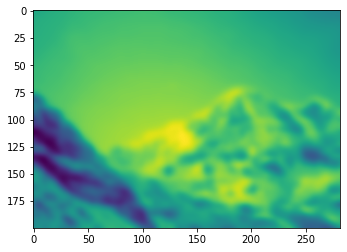

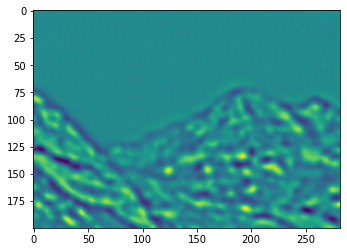

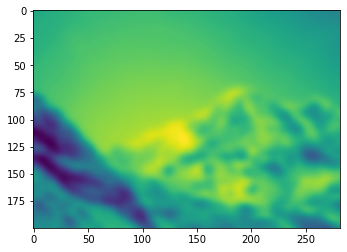

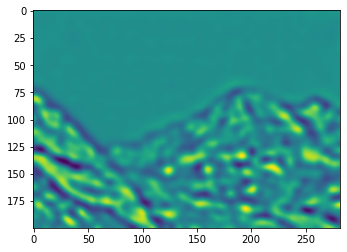

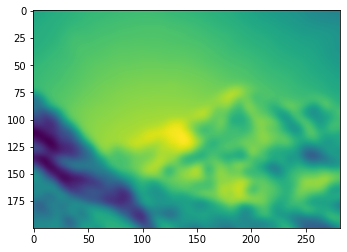

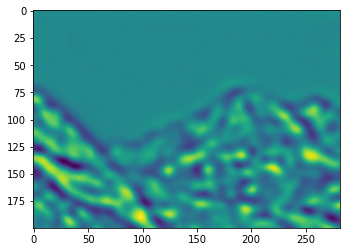

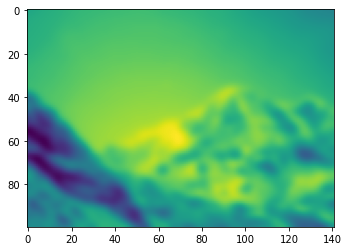

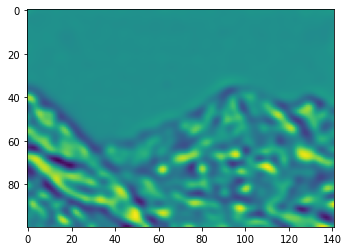

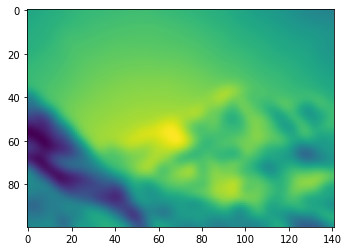

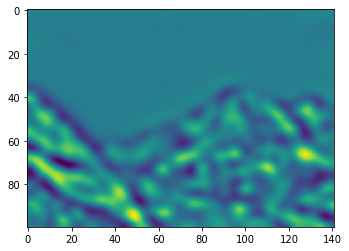

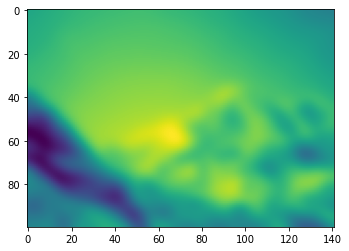

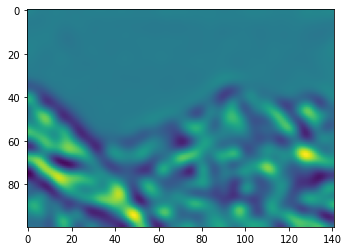

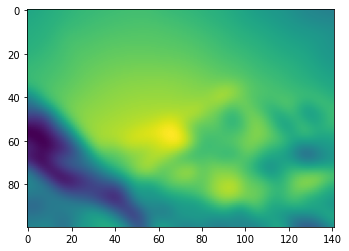

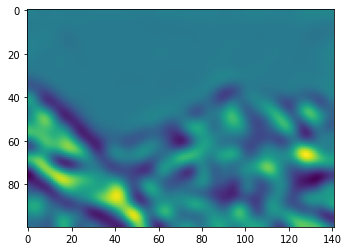

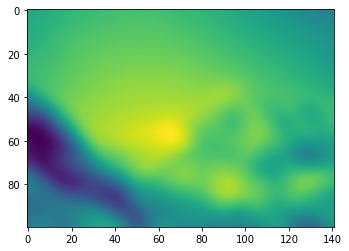

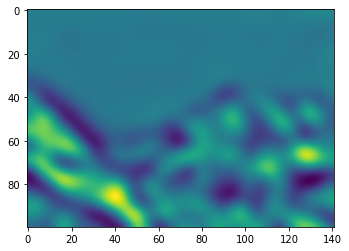

In [103]:
print(np.min(dog_pyramid[0][0]))
for i in range(n_octaves):
    for j in range(5):
        plt.imshow(img_pyramid[i][j])
        plt.show()
        plt.imshow(dog_pyramid[i][j])
        plt.show()

In [104]:
K = 3
t=1
for octave in range(n_octaves):
    dog_octave = dog_pyramid[octave]
    for scale in range(1, n_scales+1):
        scale_space = dog_octave[scale - 1: scale +2]
        h,w = scale_space[0].shape
        for i in range(1,h-1):
            for j in range(1,w-1):
                center_pixel = scale_space[1][i,j]
                if abs(center_pixel) > 0.03:
                    
                    print( (center_pixel > scale_space[0][i-1:i+2,j-1:j+2]).all() )
                    maxima = (center_pixel > scale_space[0][i-1:i+2,j-1:j+2]).all() and \
                              (center_pixel > scale_space[2][i-1:i+2,j-1:j+2]).all() and \
                              (center_pixel > scale_space[1][i-1:i+2,j-1]).all() and \
                              (center_pixel > scale_space[1][i-1:i+2,j+1]).all() and \
                              (center_pixel > scale_space[1][i-1,j]) and \
                              (center_pixel > scale_space[1][i+1,j])

                    minima = (center_pixel < scale_space[0][i-1:i+2,j-1:j+2]).all() and \
                              (center_pixel < scale_space[2][i-1:i+2,j-1:j+2]).all() and \
                              (center_pixel < scale_space[1][i-1:i+2,j-1]).all() and \
                              (center_pixel < scale_space[1][i-1:i+2,j+1]).all() and \
                              (center_pixel < scale_space[1][i-1,j]) and \
                              (center_pixel < scale_space[1][i+1,j])
                    if maxima or minima:
                        t+=1
                        
                
                            
        '''
        #print(scale_space[1].shape, center_pixels.shape)
        p1r1 = np.logical_and(np.logical_and(np.less(scale_space[0][:-2,:-2], center_pixels), 
                             np.less(scale_space[0][:-2,:1:-1], center_pixels)),
                             np.less(scale_space[0][:-2,2:], center_pixels))
        p1r2 = np.logical_and(np.logical_and(np.less(scale_space[0][1:-1,:-2], center_pixels), 
                             np.less(scale_space[0][1:-1,:1:-1], center_pixels)),
                             np.less(scale_space[0][1:-1,2:], center_pixels))
        p1r3 = np.logical_and(np.logical_and(np.less(scale_space[0][2:,:-2], center_pixels), 
                             np.less(scale_space[0][2:,:1:-1], center_pixels)),
                             np.less(scale_space[0][2:,2:], center_pixels))
        p1 = np.logical_and(np.logical_and(p1r1,p1r2),p1r3)
        
        p2r1 = np.logical_and(np.logical_and(np.less(scale_space[1][:-2,:-2], center_pixels), 
                             np.less(scale_space[1][:-2,:1:-1], center_pixels)),
                             np.less(scale_space[1][:-2,2:], center_pixels))
        p2r2 = np.logical_and(np.less(scale_space[1][1:-1,:-2], center_pixels),
                             np.less(scale_space[1][1:-1,2:], center_pixels))
        p2r3 = np.logical_and(np.logical_and(np.less(scale_space[1][2:,:-2], center_pixels), 
                             np.less(scale_space[1][2:,:1:-1], center_pixels)),
                             np.less(scale_space[1][2:,2:], center_pixels))
        p2 = np.logical_and(np.logical_and(p2r1,p2r2),p2r3)
        
        p3r1 = np.logical_and(np.logical_and(np.less(scale_space[2][:-2,:-2], center_pixels), 
                             np.less(scale_space[2][:-2,:1:-1], center_pixels)),
                             np.less(scale_space[2][:-2,2:], center_pixels))
        p3r2 = np.logical_and(np.logical_and(np.less(scale_space[2][1:-1,:-2], center_pixels), 
                             np.less(scale_space[2][1:-1,:1:-1], center_pixels)),
                             np.less(scale_space[2][1:-1,2:], center_pixels))
        p3r3 = np.logical_and(np.logical_and(np.less(scale_space[2][2:,:-2], center_pixels), 
                             np.less(scale_space[2][2:,:1:-1], center_pixels)),
                             np.less(scale_space[2][2:,2:], center_pixels))
        p3 = np.logical_and(np.logical_and(p3r1,p3r2),p3r3)
        
        out = np.logical_and(np.logical_and(p1,p2),p3)
        print(np.sum(out))
        '''
        
        
    

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [94]:
t

20